##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature columns visualization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github.com/tensorflow/examples/blob/master/community/en/hashing_trick.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/tree/master/community/en/hashing_trick.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

This example demonstrates the use `tf.feature_column.crossed_column` on some simulated Atlanta housing price data. 
This spatial data is used primarily so the results can be easily visualized. 

These functions are designed primarily for categorical data, not to build interpolation tables. 

If you actually want to build smart interpolation tables in TensorFlow you may want to consider [TensorFlow Lattice](https://research.googleblog.com/2017/10/tensorflow-lattice-flexibility.html).

## Setup

In [0]:
import os
import subprocess
import tempfile

import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
mpl.rcParams['figure.figsize'] = 12, 6
mpl.rcParams['image.cmap'] = 'viridis'

## Build Synthetic Data

In [0]:
# Define the grid
min_latitude = 33.641336
max_latitude = 33.887157
delta_latitude = max_latitude-min_latitude

min_longitude = -84.558798
max_longitude = -84.287259
delta_longitude = max_longitude-min_longitude

resolution = 100

In [0]:
# Use RandomState so the behavior is repeatable. 
R = np.random.RandomState(1)

In [0]:
# The price data will be a sum of Gaussians, at random locations.
n_centers = 20
centers = R.rand(n_centers, 2)  # shape: (centers, dimensions)

In [0]:
# Each Gaussian has a maximum price contribution, at the center.
# Price_
price_delta = 0.5+2*R.rand(n_centers)

In [0]:
# Each Gaussian also has a standard-deviation and variance.
std = 0.2*R.rand(n_centers)  # shape: (centers)
var = std**2

In [0]:
def price(latitude, longitude):
    # Convert latitude, longitude to x,y in [0,1]
    x = (longitude - min_longitude)/delta_longitude
    y = (latitude - min_latitude)/delta_latitude
    
    # Cache the shape, and flatten the inputs.
    shape = x.shape
    assert y.shape == x.shape
    x = x.flatten()
    y = y.flatten()
    
    # Convert x, y examples into an array with shape (examples, dimensions)
    xy = np.array([x,y]).T

    # Calculate the square distance from each example to each center.  
    components2 = (xy[:,None,:] - centers[None,:,:])**2  # shape: (examples, centers, dimensions)
    r2 = components2.sum(axis=2)  # shape: (examples, centers)
    
    # Calculate the z**2 for each example from each center.
    z2 = r2/var[None,:]
    price = (np.exp(-z2)*price_delta).sum(1)  # shape: (examples,)
    
    # Restore the original shape.
    return price.reshape(shape)

In [0]:
# Build the grid. We want `resolution` cells between `min` and `max` on each dimension
# so we need `resolution+1` evenly spaced edges. The centers are at the average of the
# upper and lower edge. 

latitude_edges = np.linspace(min_latitude, max_latitude, resolution+1)
latitude_centers = (latitude_edges[:-1] + latitude_edges[1:])/2

longitude_edges = np.linspace(min_longitude, max_longitude, resolution+1)
longitude_centers = (longitude_edges[:-1] + longitude_edges[1:])/2

latitude_grid, longitude_grid = np.meshgrid(
    latitude_centers,
    longitude_centers)

In [85]:
# Evaluate the price at each center-point
actual_price_grid = price(latitude_grid, longitude_grid)

price_min = actual_price_grid.min()
price_max = actual_price_grid.max()
price_mean = actual_price_grid.mean()
price_mean

0.8754787233855683

In [0]:
def show_price(price):
    plt.imshow(
        price, 
        # The color axis goes from `price_min` to `price_max`.
        vmin=price_min, vmax=price_max,
        # Put the image at the correct latitude and longitude.
        extent=(min_longitude, max_longitude, min_latitude, max_latitude), 
        # Make the image square.
        aspect = 1.0*delta_longitude/delta_latitude)

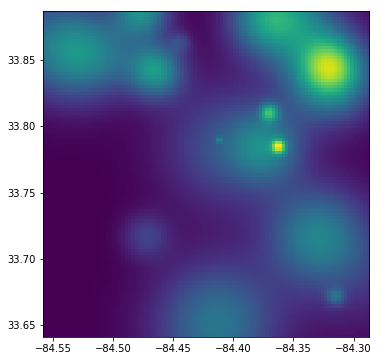

In [87]:
show_price(actual_price_grid)

## Build Datasets

In [0]:
# For test data we will use the grid centers.
test_features = {'latitude':latitude_grid.flatten(), 'longitude':longitude_grid.flatten()}
test_ds = tf.data.Dataset.from_tensor_slices((test_features, 
                                           actual_price_grid.flatten()))
test_ds = test_ds.cache().batch(512).prefetch(1)

# For training data we will use a set of random points.
train_latitude = min_latitude + np.random.rand(50000)*delta_latitude
train_longitude = min_longitude + np.random.rand(50000)*delta_longitude
train_price = price(train_latitude, train_longitude)

train_features = {'latitude':train_latitude, 'longitude':train_longitude}
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_price))
train_ds = train_ds.cache().shuffle(100000).batch(512).prefetch(1)

## Generate a plot from an Estimator

In [89]:
ag = actual_price_grid.reshape(resolution, resolution)
ag.shape

(100, 100)

In [0]:
def plot_model(model, ds = test_ds):
    # Create two plot axes
    actual, predicted = plt.subplot(1,2,1), plt.subplot(1,2,2)

    # Plot the actual price.
    plt.sca(actual)
    plt.pcolor(actual_price_grid.reshape(resolution, resolution))
    
    # Generate predictions over the grid from the estimator.
    pred =  model.predict(ds)
    # Convert them to a numpy array.
    pred = np.fromiter((item for item in pred), np.float32)
    # Plot the predictions on the secodn axis.
    plt.sca(predicted)
    plt.pcolor(pred.reshape(resolution, resolution))

## A linear regressor

In [0]:
# Use `normalizer_fn` so that the model only sees values in [0, 1]
norm_latitude = lambda latitude:(latitude-min_latitude)/delta_latitude - 0.5
norm_longitude = lambda longitude:(longitude-min_longitude)/delta_longitude - 0.5

linear_fc = [tf.feature_column.numeric_column('latitude', normalizer_fn = norm_latitude), 
             tf.feature_column.numeric_column('longitude', normalizer_fn = norm_longitude)]

In [92]:
# Build and train the model
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns=linear_fc),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())

model.fit(train_ds, epochs=200, validation_data=test_ds)

Train for 98 steps, validate for 20 steps
Epoch 1/200
98/98 [==============================] - 1s 10ms/step - loss: 0.8866 - val_loss: 0.8337
Epoch 2/200
98/98 [==============================] - 1s 5ms/step - loss: 0.8007 - val_loss: 0.7549
Epoch 3/200
98/98 [==============================] - 0s 5ms/step - loss: 0.7253 - val_loss: 0.6867
Epoch 4/200
98/98 [==============================] - 1s 5ms/step - loss: 0.6609 - val_loss: 0.6308
Epoch 5/200
98/98 [==============================] - 0s 5ms/step - loss: 0.6102 - val_loss: 0.5872
Epoch 6/200
98/98 [==============================] - 0s 5ms/step - loss: 0.5718 - val_loss: 0.5558
Epoch 7/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5442 - val_loss: 0.5328
Epoch 8/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5241 - val_loss: 0.5152
Epoch 9/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5081 - val_loss: 0.5016
Epoch 10/200
98/98 [==============================] - 0s 4ms/step 

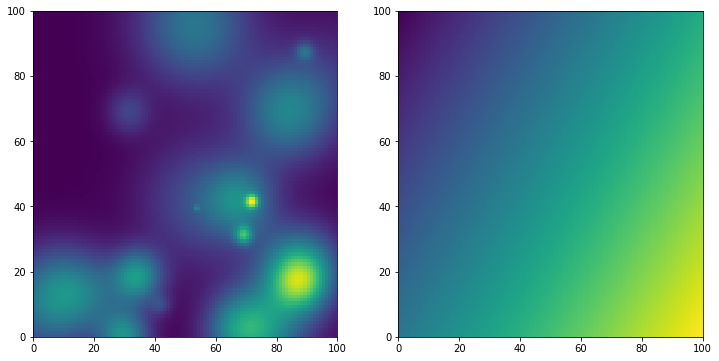

In [93]:
plot_model(model)

## A DNN regressor
Important: Pure categorical data doesn't the spatial relationships that make this example possible. Embeddings are a way your model can learn spatial relationships.

In [94]:
# Build and train the model
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns=linear_fc),
    tf.keras.layers.Dense(100, activation='elu'),
    tf.keras.layers.Dense(100, activation='elu'),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())

model.fit(train_ds, epochs=200, validation_data=test_ds)

Train for 98 steps, validate for 20 steps
Epoch 1/200
98/98 [==============================] - 1s 11ms/step - loss: 0.4912 - val_loss: 0.4520
Epoch 2/200
98/98 [==============================] - 1s 7ms/step - loss: 0.4475 - val_loss: 0.4470
Epoch 3/200
98/98 [==============================] - 1s 7ms/step - loss: 0.4363 - val_loss: 0.4255
Epoch 4/200
98/98 [==============================] - 1s 6ms/step - loss: 0.4069 - val_loss: 0.4051
Epoch 5/200
98/98 [==============================] - 1s 6ms/step - loss: 0.3944 - val_loss: 0.3955
Epoch 6/200
98/98 [==============================] - 1s 6ms/step - loss: 0.3887 - val_loss: 0.3902
Epoch 7/200
98/98 [==============================] - 1s 5ms/step - loss: 0.3828 - val_loss: 0.3859
Epoch 8/200
98/98 [==============================] - 1s 5ms/step - loss: 0.3783 - val_loss: 0.3817
Epoch 9/200
98/98 [==============================] - 1s 5ms/step - loss: 0.3729 - val_loss: 0.3737
Epoch 10/200
98/98 [==============================] - 1s 5ms/step 

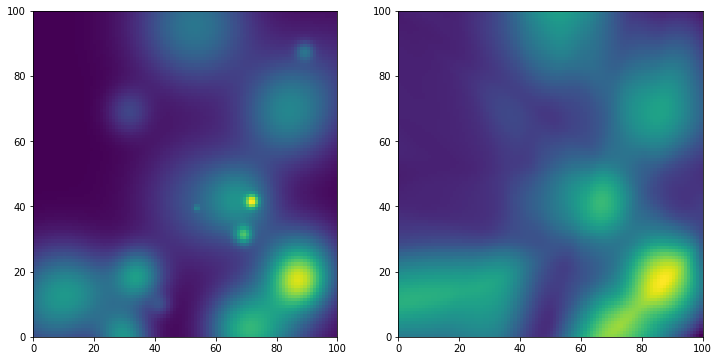

In [95]:
plot_model(model)

# Linear model with buckets

In [0]:
# Bucketize the latitude and longitude usig the `edges`
latitude_bucket_fc = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('latitude'), 
    list(latitude_edges))

longitude_bucket_fc = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('longitude'),
    list(longitude_edges))

seperable_fc = [
    latitude_bucket_fc,
    longitude_bucket_fc]

In [97]:
# Build and train the model
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns=seperable_fc),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())

model.fit(train_ds, epochs=200, validation_data=test_ds)

Train for 98 steps, validate for 20 steps
Epoch 1/200
98/98 [==============================] - 1s 10ms/step - loss: 0.7665 - val_loss: 0.6839
Epoch 2/200
98/98 [==============================] - 1s 6ms/step - loss: 0.6292 - val_loss: 0.5823
Epoch 3/200
98/98 [==============================] - 1s 6ms/step - loss: 0.5495 - val_loss: 0.5214
Epoch 4/200
98/98 [==============================] - 1s 6ms/step - loss: 0.5003 - val_loss: 0.4818
Epoch 5/200
98/98 [==============================] - 1s 5ms/step - loss: 0.4654 - val_loss: 0.4525
Epoch 6/200
98/98 [==============================] - 1s 6ms/step - loss: 0.4393 - val_loss: 0.4301
Epoch 7/200
98/98 [==============================] - 1s 5ms/step - loss: 0.4195 - val_loss: 0.4138
Epoch 8/200
98/98 [==============================] - 1s 5ms/step - loss: 0.4050 - val_loss: 0.4018
Epoch 9/200
98/98 [==============================] - 1s 6ms/step - loss: 0.3939 - val_loss: 0.3928
Epoch 10/200
98/98 [==============================] - 1s 6ms/step 

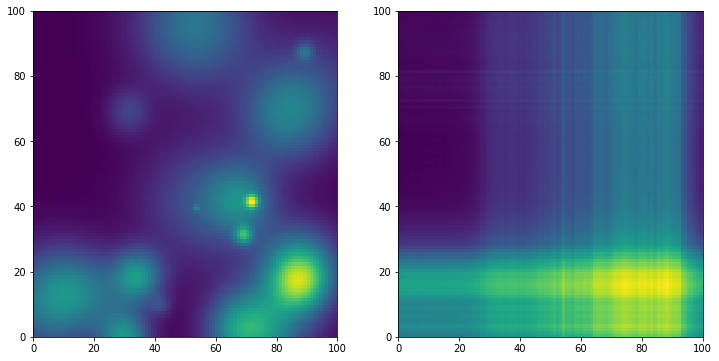

In [98]:
plot_model(model)

# Using `crossed_column` on its own.

In [99]:
# Cross the bucketized columns, using 5000 hash bins (for an average weight sharing of 2).
crossed_lat_lon_fc = tf.feature_column.crossed_column(
    [latitude_bucket_fc, longitude_bucket_fc], 2000)
crossed_lat_lon_fc = tf.feature_column.indicator_column(crossed_lat_lon_fc)


crossed_fc = [crossed_lat_lon_fc]

# Build and train the model
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns=crossed_fc),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())

model.fit(train_ds, epochs=200, validation_data=test_ds)

ERROR! Session/line number was not unique in database. History logging moved to new session 60
Train for 98 steps, validate for 20 steps
Epoch 1/200
98/98 [==============================] - 1s 15ms/step - loss: 0.8193 - val_loss: 0.7714
Epoch 2/200
98/98 [==============================] - 1s 9ms/step - loss: 0.7331 - val_loss: 0.6980
Epoch 3/200
98/98 [==============================] - 1s 9ms/step - loss: 0.6693 - val_loss: 0.6455
Epoch 4/200
98/98 [==============================] - 1s 9ms/step - loss: 0.6244 - val_loss: 0.6095
Epoch 5/200
98/98 [==============================] - 1s 9ms/step - loss: 0.5933 - val_loss: 0.5848
Epoch 6/200
98/98 [==============================] - 1s 9ms/step - loss: 0.5720 - val_loss: 0.5685
Epoch 7/200
98/98 [==============================] - 1s 9ms/step - loss: 0.5572 - val_loss: 0.5569
Epoch 8/200
98/98 [==============================] - 1s 9ms/step - loss: 0.5461 - val_loss: 0.5482
Epoch 9/200
98/98 [==============================] - 1s 9ms/step - los

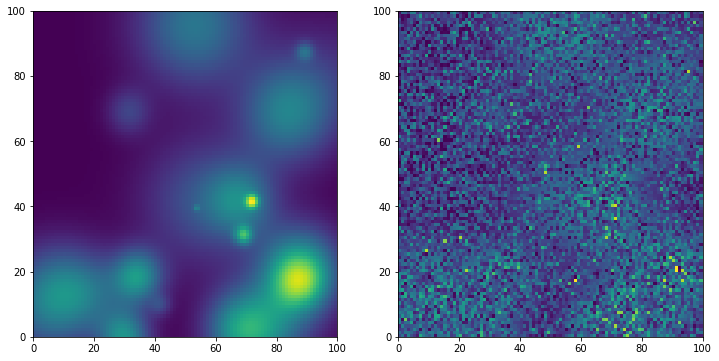

In [100]:
plot_model(model)

# Using raw categories with `crossed_column` 
The model generalizes better if it also has access to the raw categories, outside of the cross. 

In [101]:
# Build and train the model
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns=crossed_fc+seperable_fc),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=[tf.keras.losses.MeanAbsoluteError()])

model.fit(train_ds, epochs=200, validation_data=test_ds)

Train for 98 steps, validate for 20 steps
Epoch 1/200
98/98 [==============================] - 2s 21ms/step - loss: 0.7652 - mean_absolute_error: 0.7649 - val_loss: 0.6719 - val_mean_absolute_error: 0.6714
Epoch 2/200
98/98 [==============================] - 1s 13ms/step - loss: 0.6120 - mean_absolute_error: 0.6112 - val_loss: 0.5637 - val_mean_absolute_error: 0.5626
Epoch 3/200
98/98 [==============================] - 1s 13ms/step - loss: 0.5290 - mean_absolute_error: 0.5275 - val_loss: 0.5017 - val_mean_absolute_error: 0.4999
Epoch 4/200
98/98 [==============================] - 1s 13ms/step - loss: 0.4768 - mean_absolute_error: 0.4747 - val_loss: 0.4612 - val_mean_absolute_error: 0.4588
Epoch 5/200
98/98 [==============================] - 1s 13ms/step - loss: 0.4422 - mean_absolute_error: 0.4395 - val_loss: 0.4337 - val_mean_absolute_error: 0.4307
Epoch 6/200
98/98 [==============================] - 1s 10ms/step - loss: 0.4173 - mean_absolute_error: 0.4140 - val_loss: 0.4137 - val_me

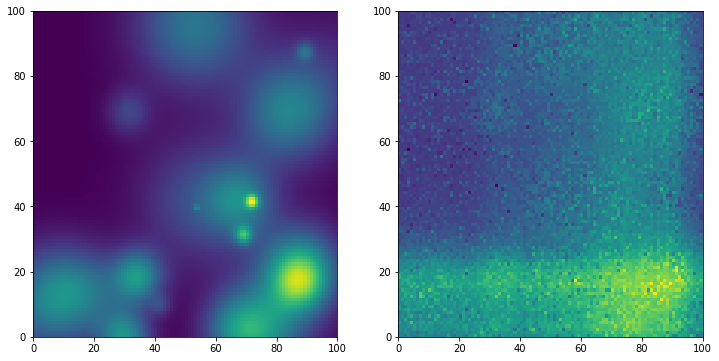

In [103]:
plot_model(model)